In [369]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
from sys import modules
import seaborn as sns
from eval_utils import my_stupid_evaluation_function,mean_absolute_error
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [519]:
#Import Data 
X_data= pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/X.csv")
y_data = pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/y.csv")

#Set index
X_data = X_data.set_index('id')
y_data = y_data.set_index('id')

#join
df = X_data.join(y_data, on = 'id') 

#Copy
input_df = df


In [293]:
RATIO_KEEPER = 0.05
OUTLIER_DEFINITION = 3

gender_mapper = {"F":0,"M":1,"O":2}

In [525]:
#Columns and type
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5363 entries, 2477 to 3572
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0.1         5363 non-null   int64  
 1   Unnamed: 0           5363 non-null   int64  
 2   Age                  5359 non-null   float64
 3   Gender               5359 non-null   object 
 4   Education Level      5360 non-null   object 
 5   Job Title            5361 non-null   object 
 6   Years of Experience  5360 non-null   float64
 7   Country              5363 non-null   object 
 8   Race                 5363 non-null   object 
 9   height               5363 non-null   float64
 10  weight               5361 non-null   float64
 11  professionalism      5360 non-null   float64
 12  Salary               5358 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 586.6+ KB
None


In [526]:
#remove_outliers
def preprocess_df(df, ratio_keeper = 0.05, outlier_definition = 3):
    df = input_df.copy()

    #Removing some bad things:
    df = df.dropna()

    #df[(df["professionalism"] / df["Years of Experience"]).between(1-Ratio_keeper, 1+Ratio_keeper)] #What is 100%
    df = df[(df["professionalism"] / df["Years of Experience"]).between(5,60)]

    df["Ratio"] = df["professionalism"] / df["Years of Experience"]
    df["Age_Ratio"] = df["Ratio"] / df["Age"]
  
    Age_Ratio_normad = (df['Age_Ratio']-df['Age_Ratio'].mean())/df['Age_Ratio'].std()
    df = df[Age_Ratio_normad.between(-1 * outlier_definition, 1 * outlier_definition)]

    df["Gender"] = df["Gender"].map(gender_mapper) 

    one_hot_encoded = pd.get_dummies(df["Education Level"], prefix="Job")
    df = pd.concat([df, one_hot_encoded], axis=1)

    target_encoder = ce.TargetEncoder()
    df["Job Title Encoded"] = target_encoder.fit_transform(df["Job Title"], df["Salary"])

    #Drop Retendent Columns
    df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
    #Drop Category Column
    #df = df.drop(['Education Level', 'Job Title', "Country","Race"], axis=1)
    
    return df    

df = preprocess_df(input_df,"""RATIO_KEEPER = Ratio_keeper,""",outlier_definition = OUTLIER_DEFINITION)

In [527]:
#Columns and type
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5266 entries, 2477 to 3572
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5266 non-null   float64
 1   Gender               5266 non-null   int64  
 2   Education Level      5266 non-null   object 
 3   Job Title            5266 non-null   object 
 4   Years of Experience  5266 non-null   float64
 5   Country              5266 non-null   object 
 6   Race                 5266 non-null   object 
 7   height               5266 non-null   float64
 8   weight               5266 non-null   float64
 9   professionalism      5266 non-null   float64
 10  Salary               5266 non-null   float64
 11  Ratio                5266 non-null   float64
 12  Age_Ratio            5266 non-null   float64
 13  Job_bachelor         5266 non-null   uint8  
 14  Job_bachelor's|degr  5266 non-null   uint8  
 15  Job_high|scho        5266 non-null 

In [529]:
class MySuperModel:
    def __init__(self, cols):
        """cols is a list of columns"""
        self.cols = cols

    def fit(self, X, y):

        #X and y are the ones from the training set
        self.col_salary_mapper_ = y.groupby([X[col] for col in self.cols]).mean().rename("y_hat")
        self.fallback_salary_s_ = y.mean()

    def predict(self, X):
        
        """We can assume that X contains a column named self.col"""
        out = X.join(self.col_salary_mapper_, on = self.cols)
        out = out["y_hat"]
        out = out.fillna(self.fallback_salary_s_) #What we didn't predict well will be in fallback price
        return out  

class MyTransformer:
    """ 
    A transformer that transforms the column "col" from "raw" variant into standardized variant
    """
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        self.avg_ = X[self.col].mean()
        self.std_ = X[self.col].std()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.col] = (X[self.col] - self.avg_) / self.std_
        # Apply your categorization logic for "Job Title" and "Education Level" here
        return X_transformed
    
column_transformer = MyTransformer(col = 'Age_Ratio')
column_transformer.fit(df)

In [541]:
#Columns and type
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5266 entries, 2477 to 3572
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5266 non-null   float64
 1   Gender               5266 non-null   int64  
 2   Education Level      5266 non-null   object 
 3   Job Title            5266 non-null   object 
 4   Years of Experience  5266 non-null   float64
 5   Country              5266 non-null   object 
 6   Race                 5266 non-null   object 
 7   height               5266 non-null   float64
 8   weight               5266 non-null   float64
 9   professionalism      5266 non-null   float64
 10  Salary               5266 non-null   float64
 11  Ratio                5266 non-null   float64
 12  Age_Ratio            5266 non-null   float64
 13  Job_bachelor         5266 non-null   uint8  
 14  Job_bachelor's|degr  5266 non-null   uint8  
 15  Job_high|scho        5266 non-null 

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary,Ratio,Age_Ratio,Job_bachelor,Job_bachelor's|degr,Job_high|scho,Job_master,Job_master's|degr,Job_p,Job Title Encoded
id,,,,,,,,,,,,,,,,,,,,
2477,52.0,1,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0,47.916667,0.921474,0,1,0,0,0,0,103767.631104
76,52.0,0,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0,47.826087,0.919732,1,0,0,0,0,0,95348.020290
64,27.0,1,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0,13.000000,0.481481,1,0,0,0,0,0,105438.971247
924,32.0,1,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0,25.363636,0.792614,1,0,0,0,0,0,125118.705036
242,39.0,0,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0,34.545455,0.885781,1,0,0,0,0,0,115478.324624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,30.0,0,master's|degr,back|end|develope,5.0,australi,Asian,2.189504,41.395949,87.0,90000.0,17.400000,0.580000,0,0,0,0,1,0,103767.631104
354,32.0,0,bachelor,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0,23.250000,0.726562,1,0,0,0,0,0,100732.302780
3677,44.0,1,p,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,140000.0,36.400000,0.827273,0,0,0,0,0,1,166034.285714


In [277]:
X, y = df.drop("Salary", axis=1), df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [278]:
#The transformation pipeline

my_scalar = StandardScaler()
my_scalar.fit(X_train)

X_train_transformed = my_scalar.transform(X_train)
X_test_transformed = my_scalar.transform(X_test)

In [279]:
from sklearn.ensemble import RandomForestRegressor

In [324]:
#0.8838268792710706
def my_eval_metric(y_true, y_pred, tol = 0.1):
    output = np.abs((y_pred - y_true)/y_true)
    output = (output < tol)
    return output.mean()

my_eval_metric(y_test, y_pred)

0.665907365223994

In [281]:
regressor = RandomForestRegressor(max_depth=20)
regressor.fit(X_train_transformed,y_train)
y_pred = regressor.predict(X_test_transformed)

In [282]:
singel_tree = regressor.estimators_[0]

In [283]:
from sklearn.tree import export_graphviz
singel_tree = regressor.estimators_[0]
export_graphviz(singel_tree, max_depth = 1)


'digraph Tree {\nnode [shape=box, fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="x[5] <= -0.501\\nsquared_error = 2740208161.185\\nsamples = 2503\\nvalue = 115778.299"] ;\n1 [label="x[14] <= -0.186\\nsquared_error = 994789384.667\\nsamples = 1058\\nvalue = 70572.944"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="(...)"] ;\n1 -> 2 ;\n505 [label="(...)"] ;\n1 -> 505 ;\n810 [label="x[2] <= 0.3\\nsquared_error = 1396647493.185\\nsamples = 1445\\nvalue = 149283.679"] ;\n0 -> 810 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n811 [label="(...)"] ;\n810 -> 811 ;\n1354 [label="(...)"] ;\n810 -> 1354 ;\n}'

In [284]:
#0.8777524677296887
regressor.fit(X_train_transformed,np.log1p(y_train))
y_pred = regressor.predict(X_test_transformed)
y_pred = np.expm1(y_pred)
mean_squared_error(y_test, y_pred)

91260298.45267944

In [325]:
model = LinearRegression()
model.fit(X_train_transformed,y_train)
y_pred = regressor.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

16713844118.41316

In [326]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

129281.63268529564

<Axes: xlabel='y_test', ylabel='y_pred'>

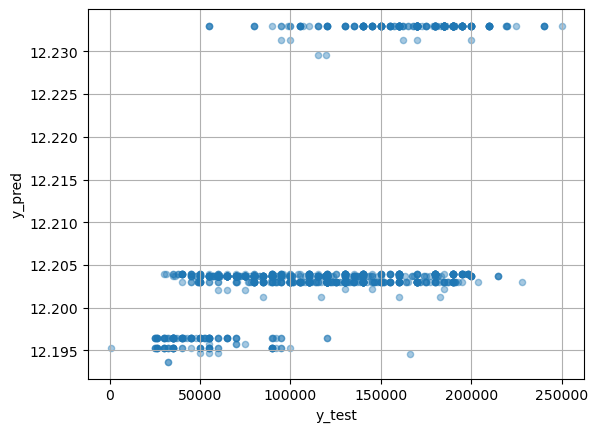

In [287]:
# Sample data (replace these with your actual data)
evaluation_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Create a scatter plot using DataFrame column names
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

In [288]:
X, y = df.drop("Salary", axis=1), df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

<Axes: xlabel='professionalism', ylabel='Years of Experience'>

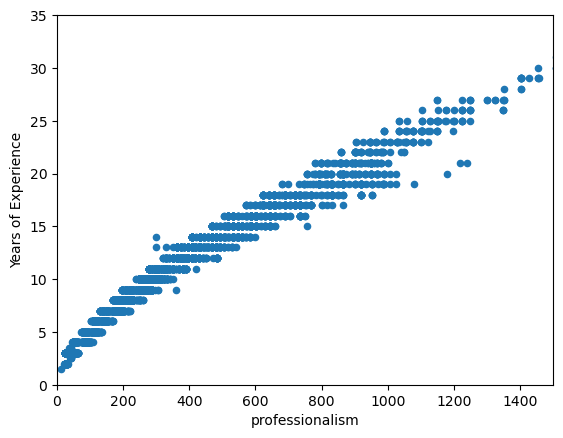

In [289]:
df.plot.scatter("professionalism","Years of Experience",xlim=(0,1500),ylim=(0,35))

In [546]:
input_df.value_counts()


Unnamed: 0.1  Unnamed: 0  Age   Gender  Education Level  Job Title                 Years of Experience  Country   Race              height    weight      professionalism  Salary  
4             4           53.0  M       master           directo                   22.0                 us        Asian             1.522019  105.799514  1040.0           200000.0    1
4502          4502        46.0  M       master's|degr    marketing|manage          21.0                 us        White             1.779366  87.186085   900.0            204000.0    1
4500          4500        35.0  M       bachelor's|degr  operations|manage         10.0                 canad     Asian             1.505021  54.236788   272.0            104000.0    1
4499          4499        34.0  F       master's|degr    marketing|manage          7.0                  u         White             2.014104  50.973926   192.0            77000.0     1
4497          4497        31.0  F       bachelor's|degr  marketing|coordinato   

In [386]:
X, y = df[['professionalism',"Job Title Encoded","Years of Experience","Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"]], df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [387]:
reg = MySuperModel(cols = ['professionalism',"Job Title Encoded","Years of Experience","Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"])
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)


In [531]:
reg.col_salary_mapper_ 

professionalism  Job Title Encoded  Job_bachelor  Job_bachelor's|degr  Job_high|scho  Job_master  Job_master's|degr  Job_p
11.5             105799.319075      1             0                    0              0           0                  0         35000.0
23.0             28309.678295       0             0                    1              0           0                  0         26000.0
                 45224.708585       0             1                    0              0           0                  0         32000.0
                 64857.438518       0             1                    0              0           0                  0         45000.0
                 65084.158938       0             0                    1              0           0                  0         35000.0
                                                                                                                                ...   
1728.0           152408.204241      0             0                

In [532]:
reg.fallback_salary_s_

116538.15674854393

In [543]:
y_pred, y_test

(array([181142.77612529,  57609.06305314, 206308.37911652, ...,
        185452.65405764,  95108.62797259, 122827.95829301]),
 id
 1975    185000.0
 5727     60000.0
 4483    219000.0
 5248     85000.0
 69      150000.0
           ...   
 1712    210000.0
 5697     90000.0
 1393    185000.0
 3984    100000.0
 3287    110000.0
 Name: Salary, Length: 1317, dtype: float64)

<Axes: xlabel='y_test', ylabel='y_pred'>

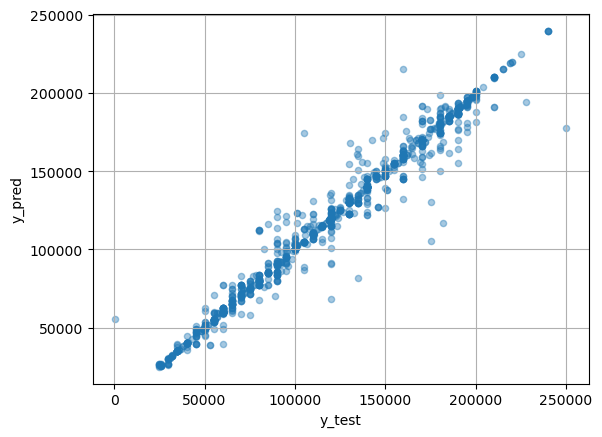

In [534]:
"""The line in the center is the fallback"""
evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

In [535]:
rmse = mean_squared_error(y_test, y_pred, squared=False) 
rmse

8145.174023554511

2992.6920502869525


<Axes: xlabel='y_test', ylabel='y_pred'>

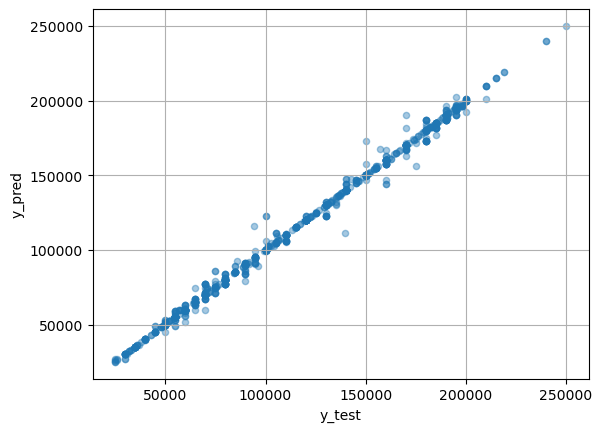

In [598]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

<Axes: xlabel='y_test', ylabel='y_pred'>

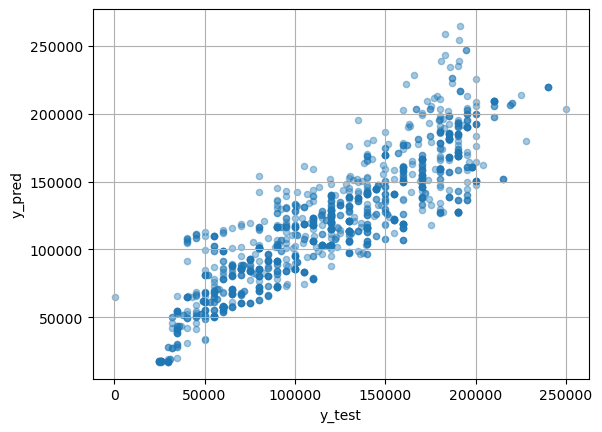

KNN

In [466]:
X, y = df[['professionalism',"Job Title Encoded","Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"]], df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

<Axes: xlabel='y_test', ylabel='y_pred'>

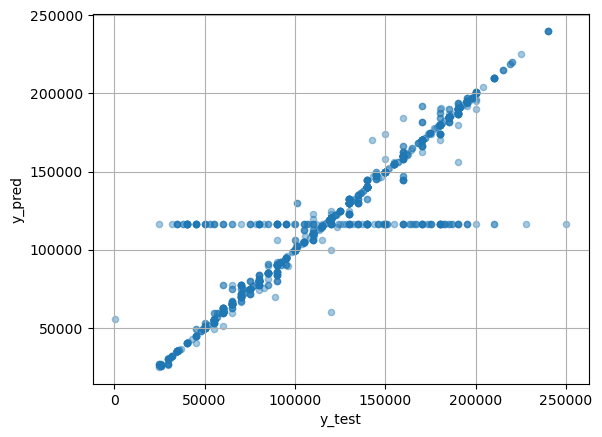

In [469]:
"""
'professionalism',"Years of Experience",
"""
reg = MySuperModel(cols = ['professionalism',"Job Title Encoded","Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"])
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

3306.5198425410235


<Axes: xlabel='y_test', ylabel='y_pred'>

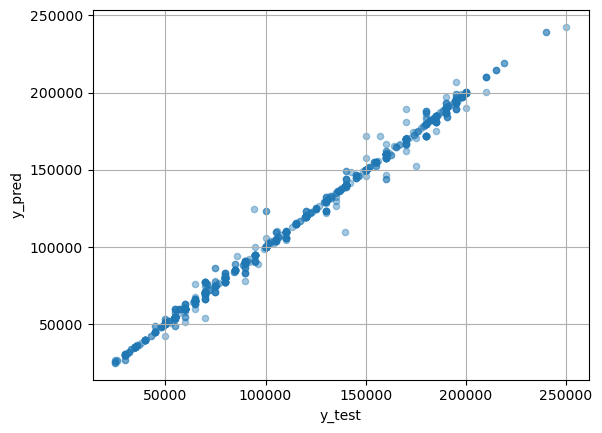

In [595]:
model = RandomForestRegressor(max_depth=20)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

4441.7927444248735


<Axes: xlabel='y_test', ylabel='y_pred'>

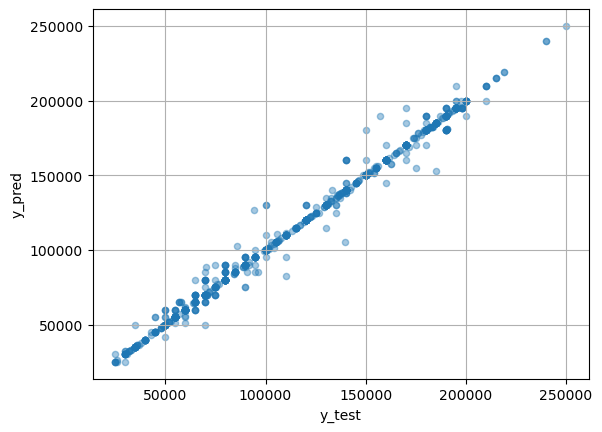

In [597]:
model = KNeighborsRegressor(n_neighbors=1, p=2)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(rmse)

evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

In [484]:
y_test

id
1975    185000.0
5727     60000.0
4483    219000.0
5248     85000.0
69      150000.0
          ...   
1712    210000.0
5697     90000.0
1393    185000.0
3984    100000.0
3287    110000.0
Name: Salary, Length: 1317, dtype: float64

In [553]:
#Columns and type
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5266 entries, 2477 to 3572
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5266 non-null   float64
 1   Gender               5266 non-null   int64  
 2   Education Level      5266 non-null   object 
 3   Job Title            5266 non-null   object 
 4   Years of Experience  5266 non-null   float64
 5   Country              5266 non-null   object 
 6   Race                 5266 non-null   object 
 7   height               5266 non-null   float64
 8   weight               5266 non-null   float64
 9   professionalism      5266 non-null   float64
 10  Salary               5266 non-null   float64
 11  Ratio                5266 non-null   float64
 12  Age_Ratio            5266 non-null   float64
 13  Job_bachelor         5266 non-null   uint8  
 14  Job_bachelor's|degr  5266 non-null   uint8  
 15  Job_high|scho        5266 non-null 

In [591]:
df_train, df_test = train_test_split(df, random_state=1, test_size=0.2)

# Grouping and calculating the mean salary for each combination of "Country" and "Gender"
elements_train = df_train.groupby(['Education Level', 'Job Title', 'professionalism'])["Salary"].mean().rename("C_y_mean_Salary")
elements_train.unstack(fill_value=elements_train.mean())
elements_train

elements_test = df_test.groupby(['Education Level', 'Job Title', 'professionalism'])["Salary"].mean().rename("C_y_mean_Salary")
elements_test.unstack(fill_value=elements_test.mean())
elements_test

# Using .map() to join the elements series back to the original DataFrame
df_train["C_y_mean_Salary"] = df_train.set_index(['Education Level', 'Job Title', 'professionalism']).index.map(elements_train)

#df_train[["Salary","C_y_mean_Salary"]]

df_test["C_y_mean_Salary"] = df_test.set_index(['Education Level', 'Job Title', 'professionalism']).index.map(elements_test)

#df_test[["Salary","C_y_mean_Salary"]]

X_train, y_train = df_train.drop("Salary", axis=1), df_train["Salary"]
X_test, y_test = df_test.drop("Salary", axis=1), df_test["Salary"]

In [593]:
X, y = df_train[["C_y_mean_Salary",'professionalism',"Job Title Encoded","Job_bachelor"  ,"Job_bachelor's|degr"  ,"Job_high|scho"  ,"Job_master"  ,"Job_master's|degr" ,"Job_p"]], df_train["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [587]:
#Columns and type
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4212 entries, 2192 to 4465
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  4212 non-null   float64
 1   Gender               4212 non-null   int64  
 2   Education Level      4212 non-null   object 
 3   Job Title            4212 non-null   object 
 4   Years of Experience  4212 non-null   float64
 5   Country              4212 non-null   object 
 6   Race                 4212 non-null   object 
 7   height               4212 non-null   float64
 8   weight               4212 non-null   float64
 9   professionalism      4212 non-null   float64
 10  Salary               4212 non-null   float64
 11  Ratio                4212 non-null   float64
 12  Age_Ratio            4212 non-null   float64
 13  Job_bachelor         4212 non-null   uint8  
 14  Job_bachelor's|degr  4212 non-null   uint8  
 15  Job_high|scho        4212 non-null 